In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing

In [29]:
class DataAnalyzer:
    def __init__(self):
        base_folder = 'wine+quality'
        whitewine_data = pd.read_csv(f'{base_folder}/winequality-white.csv', sep=';') 
        redwine_data = pd.read_csv(f'{base_folder}/winequality-red.csv', sep=';') 
        self.description_file = f'{base_folder}/winequality.names'
        self.dataset = whitewine_data

        self.results = {}

    def read_file(self):
        file_path = self.description_file

        # Open the file
        with open(file_path, 'r') as file:
            # Read lines
            lines = file.readlines()

        # Displaying the content
        for line in lines:
            print(line.strip())  
    
    def show_boxplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.boxplot(y=k, data=self.dataset, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_outlier_percs(self):
        for k, v in self.dataset.items():
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(self.dataset)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    def remove_outliers(self):
        self.dataset = self.dataset[~((self.dataset['quality'] > 7.0) | (self.dataset['quality'] < 4.0))]
        self.dataset = self.dataset[~((self.dataset['density'] > 1.01) | (self.dataset['density'] < 0.98))]
        self.dataset = self.dataset[~((self.dataset['pH'] > 3.59) | (self.dataset['pH'] < 2.78))]
        self.dataset = self.dataset[~((self.dataset['chlorides'] > 0.08))]
        self.dataset = self.dataset[~((self.dataset['volatile acidity'] > 0.5))]
        self.dataset = self.dataset[~((self.dataset['total sulfur dioxide'] > 260.0))]
        self.dataset = self.dataset[~((self.dataset['residual sugar'] > 21.0))]
        self.dataset = self.dataset[~((self.dataset['fixed acidity'] > 9.1))]
        self.dataset = self.dataset[~((self.dataset['citric acid'] > 0.65))]
        return self.dataset

    def get_x_and_Y(self):
        self.X = self.dataset.iloc[:, list(range(11))].values
        self.y = self.dataset.iloc[:, -1].values
        return (self.X, self.y)

    def get_train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.20, random_state = 0)
        return (self.X_train, self.X_test, self.y_train, self.y_test)

    def normalize_df_by_max(self):
        normalized_df = self.dataset.copy()
        for column in self.dataset.columns[:-1]:  # Exclude the last column
            max_abs_value = abs(self.dataset[column]).max()
            normalized_df[column] = self.dataset[column] / max_abs_value

        self.dataset = normalized_df
        return(self.dataset)

    def normalize_df_by_mean(self):
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.transform(self.X_test)
        return(self.X_train, self.X_test)
    
    def show_histplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.histplot(v, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_heat_map(self):
        plt.figure(figsize=(20, 10))
        sns.heatmap(self.dataset.corr().abs(),  annot=True)

    def plot_variations(self):
        # Let's scale the columns before plotting them against MEDV
        min_max_scaler = preprocessing.MinMaxScaler()
        # column_sels = ['alcohol', 'density', 'volatile acidity', 'total sulfur dioxide', 'fixed acidity', 'chlorides', 'residual sugar', 'pH']
        column_sels = self.dataset.columns
        x = self.dataset.loc[:,column_sels]
        y = self.dataset['quality']
        x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
        fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for i, k in enumerate(column_sels):
            sns.regplot(y=y, x=x[k], ax=axs[i])
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def perform_knn(self):
        classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
        classifier.fit(self.X_train, self.y_train)
        y_pred = classifier.predict(self.X_test)
        self.cm = confusion_matrix(self.y_test, y_pred)
        self.ac = accuracy_score(self.y_test,y_pred)
        return self.ac

class Master:
    def __init__(self):
        self.results = {}

    def run_raw(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        self.results["raw_run"] = anlyzr.perform_knn()

    def run_after_removing_outliers(self):
        anlyzr = DataAnalyzer()
        anlyzr.remove_outliers()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        self.results["after_removing_outliers_run"] = anlyzr.perform_knn()

    def run_after_max_normalisation(self):
        anlyzr = DataAnalyzer()
        anlyzr.remove_outliers()
        anlyzr.normalize_df_by_max()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        self.results["after_max_normalisation_run"] = anlyzr.perform_knn()

    def run_after_mean_normalisation(self):
        anlyzr = DataAnalyzer()
        anlyzr.remove_outliers()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        anlyzr.normalize_df_by_mean()
        self.results["after_mean_normalisation_run"] = anlyzr.perform_knn()

In [30]:
def master():
    mastr_func = Master()
    mastr_func.run_raw()
    mastr_func.run_after_removing_outliers()
    mastr_func.run_after_max_normalisation()
    mastr_func.run_after_mean_normalisation()
    return mastr_func.results

master()

{'raw_run': 0.40714285714285714,
 'after_removing_outliers_run': 0.5041617122473246,
 'after_max_normalisation_run': 0.5041617122473246,
 'after_mean_normalisation_run': 0.6016646848989299}

In [2]:
base_folder = 'wine+quality'
whitewine_data = pd.read_csv(f'{base_folder}/winequality-white.csv', sep=';') 
redwine_data = pd.read_csv(f'{base_folder}/winequality-red.csv', sep=';') 
description_file = f'{base_folder}/winequality.names'

dataset = whitewine_data

In [3]:
def read_file(file_name):
    file_path = file_name

    # Open the file
    with open(file_path, 'r') as file:
        # Read lines
        lines = file.readlines()

    # Displaying the content
    for line in lines:
        print(line.strip())  

In [4]:
display(dataset)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


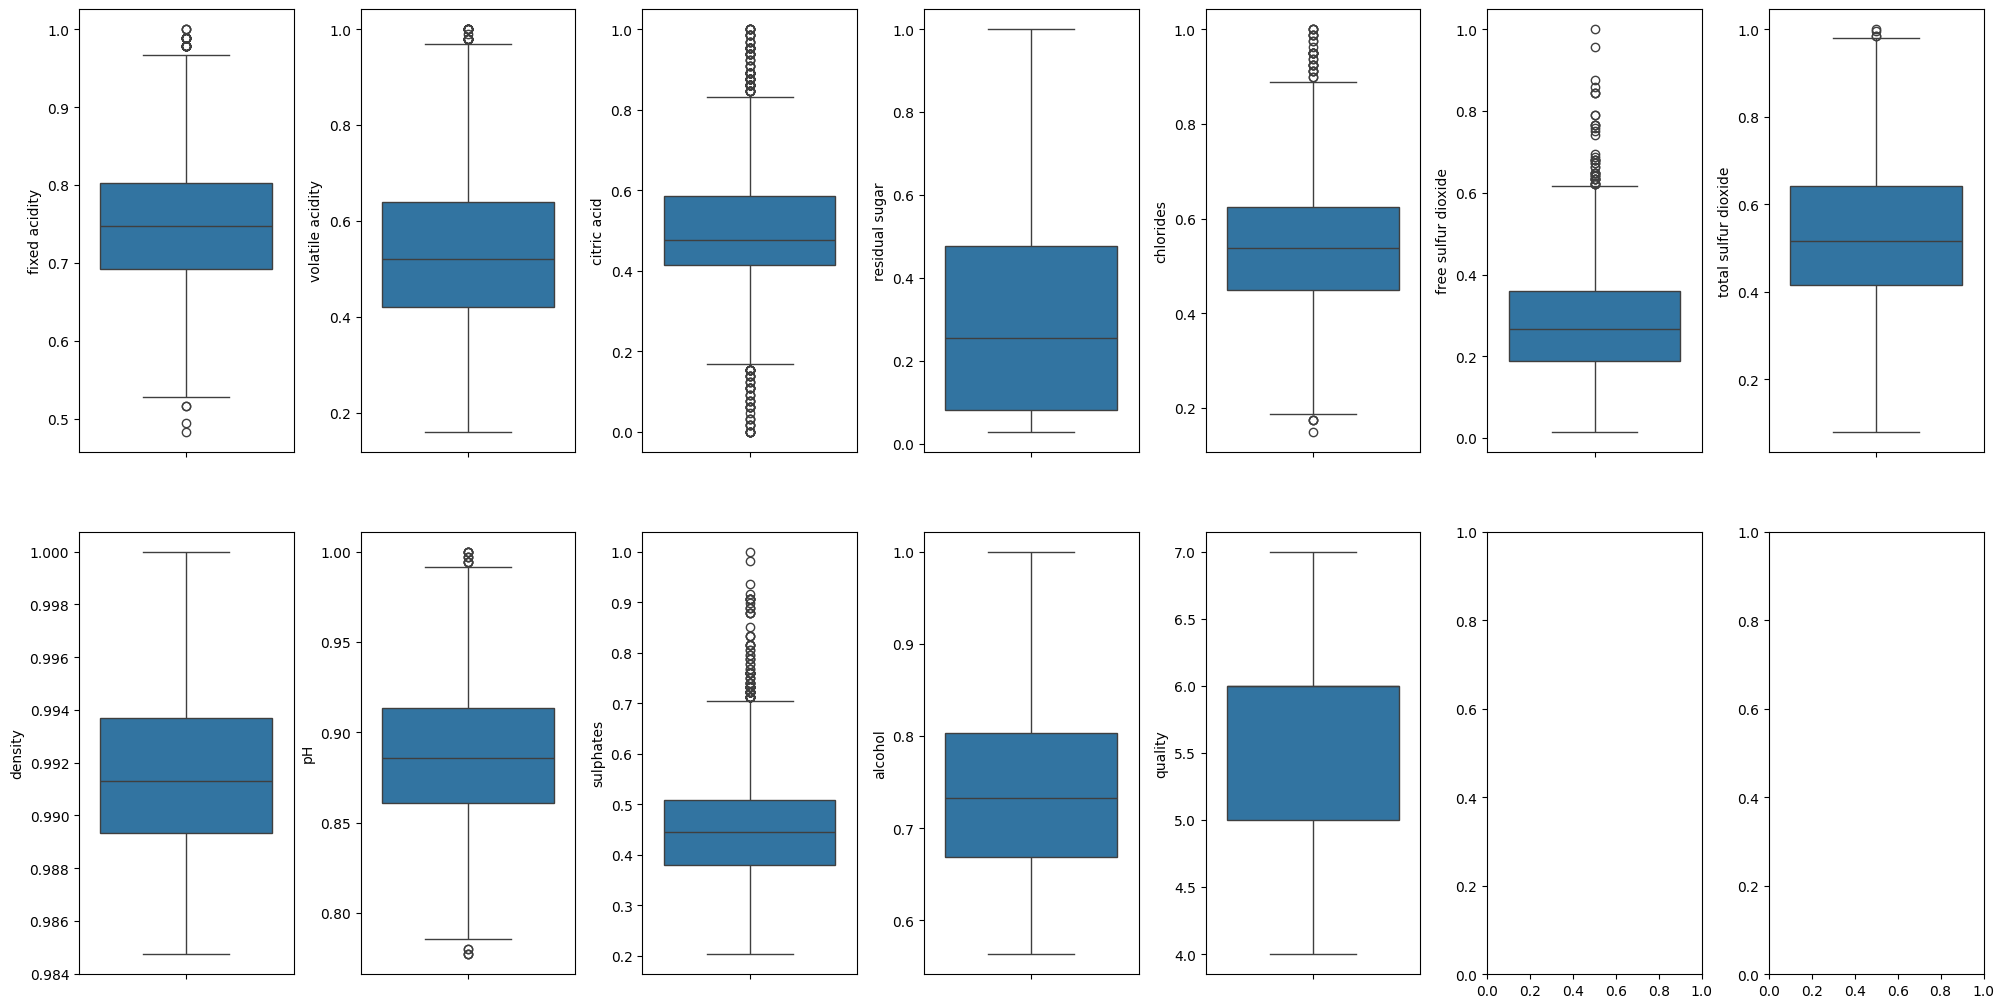

In [9]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in dataset.items():
    sns.boxplot(y=k, data=dataset, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [6]:
for k, v in dataset.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(dataset)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column fixed acidity outliers = 2.98%
Column volatile acidity outliers = 3.80%
Column citric acid outliers = 5.51%
Column residual sugar outliers = 0.14%
Column chlorides outliers = 4.25%
Column free sulfur dioxide outliers = 1.02%
Column total sulfur dioxide outliers = 0.39%
Column density outliers = 0.10%
Column pH outliers = 1.53%
Column sulphates outliers = 2.53%
Column alcohol outliers = 0.00%
Column quality outliers = 4.08%


In [6]:
# ['alcohol', 'density', 'volatile acidity', 'total sulfur dioxide', 'fixed acidity', 'chlorides', 'residual sugar', 'pH']
dataset = dataset[~((dataset['quality'] > 7.0) | (dataset['quality'] < 4.0))]
dataset = dataset[~((dataset['density'] > 1.01) | (dataset['density'] < 0.98))]
dataset = dataset[~((dataset['pH'] > 3.59) | (dataset['pH'] < 2.78))]
dataset = dataset[~((dataset['chlorides'] > 0.08))]
dataset = dataset[~((dataset['volatile acidity'] > 0.5))]
dataset = dataset[~((dataset['total sulfur dioxide'] > 260.0))]
dataset = dataset[~((dataset['residual sugar'] > 21.0))]
dataset = dataset[~((dataset['fixed acidity'] > 9.1))]
dataset = dataset[~((dataset['citric acid'] > 0.65))]
print(np.shape(dataset))

(4203, 12)


In [7]:
normalized_df = dataset.copy()
for column in dataset.columns[:-1]:  # Exclude the last column
    max_abs_value = abs(dataset[column]).max()
    normalized_df[column] = dataset[column] / max_abs_value

dataset = normalized_df

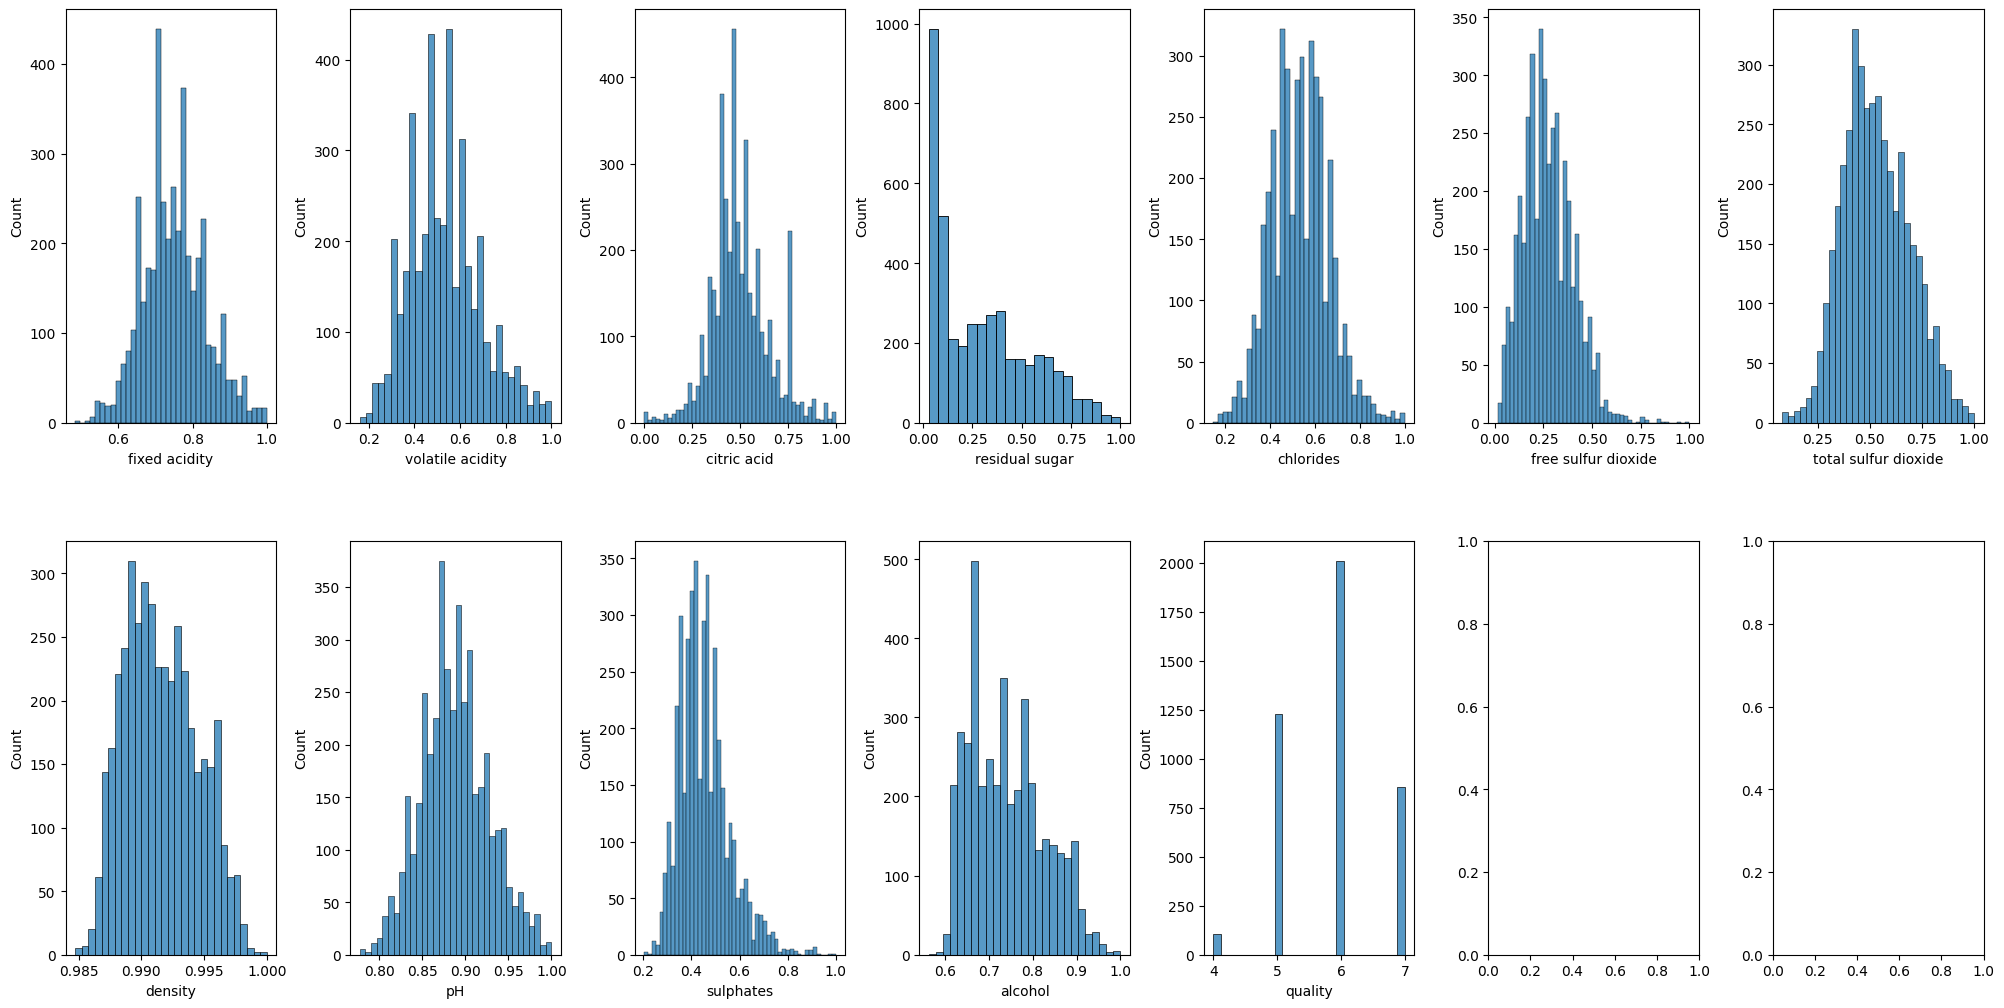

In [8]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in dataset.items():
    sns.histplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<Axes: >

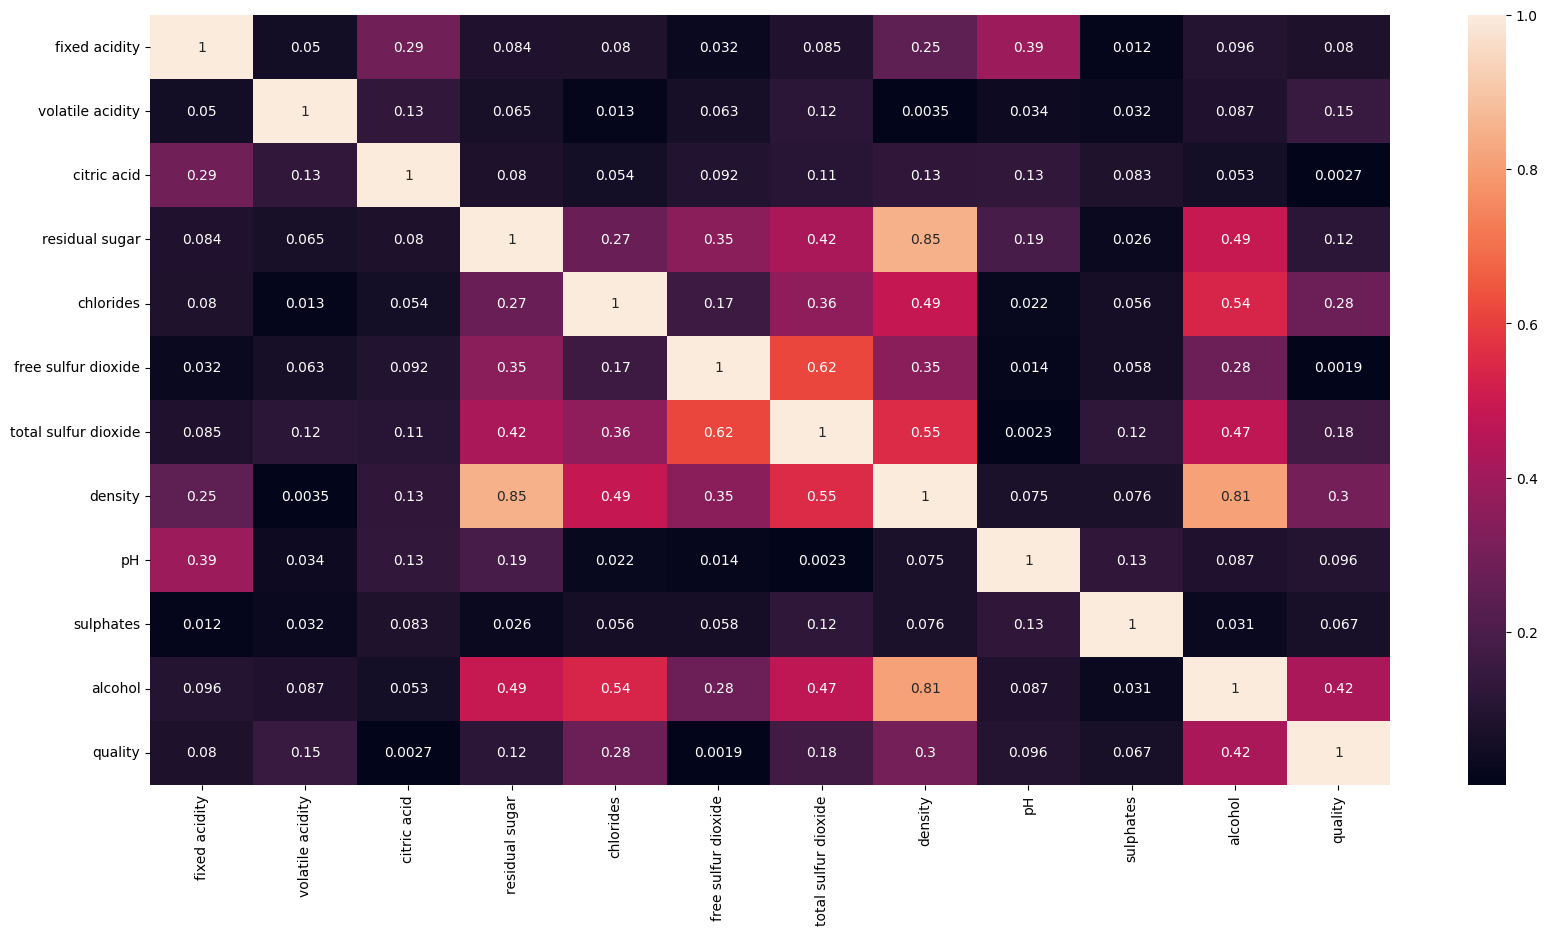

In [10]:
plt.figure(figsize=(20, 10))
sns.heatmap(dataset.corr().abs(),  annot=True)

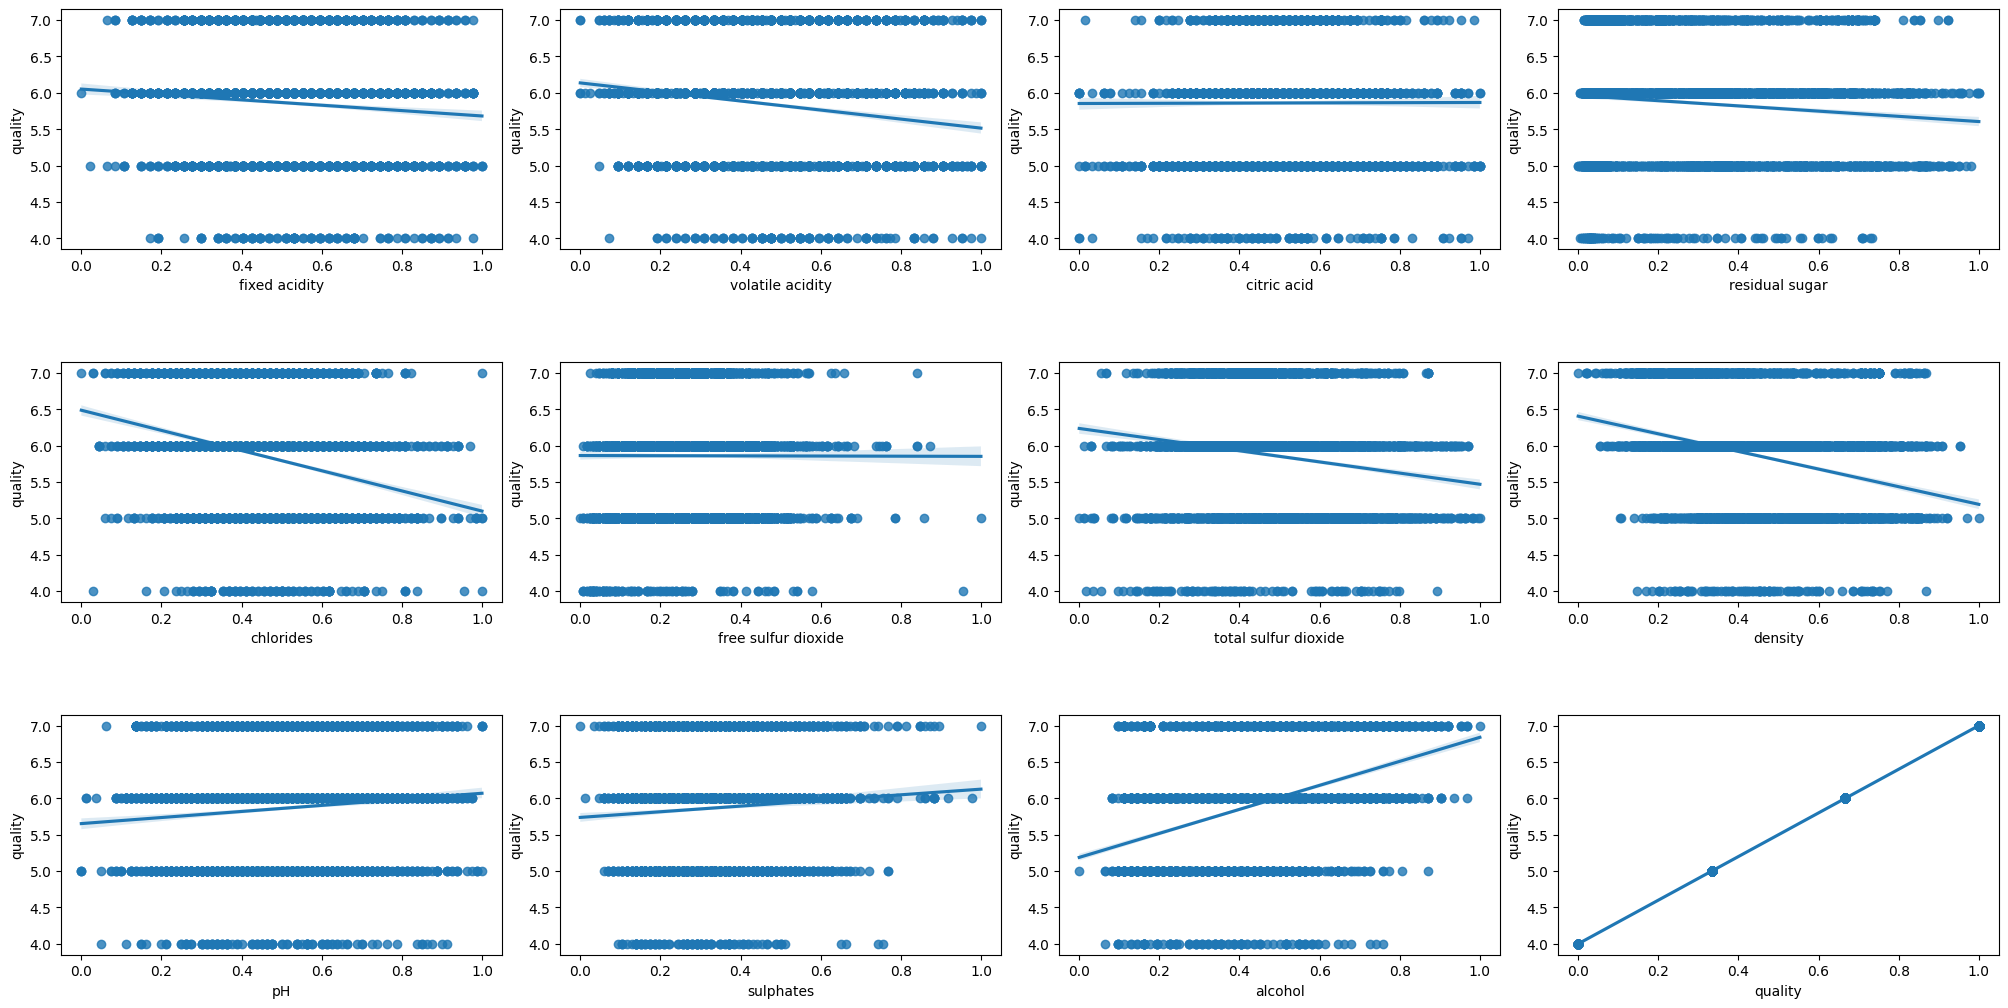

In [11]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
# column_sels = ['alcohol', 'density', 'volatile acidity', 'total sulfur dioxide', 'fixed acidity', 'chlorides', 'residual sugar', 'pH']
column_sels = dataset.columns
x = dataset.loc[:,column_sels]
y = dataset['quality']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [12]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

l_regression = linear_model.LinearRegression()
kf = KFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scores = cross_val_score(l_regression, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

scores_map = {}
scores_map['LinearRegression'] = scores
l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

# Lets try polinomial regression with L2 with degree for the best fit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
#for degree in range(2, 6):
#    model = make_pipeline(PolynomialFeatures(degree=degree), linear_model.Ridge())
#    scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
#    print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
model = make_pipeline(PolynomialFeatures(degree=3), linear_model.Ridge())
scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.00 (+/- 0.00)
MSE: -0.00 (+/- 0.00)
MSE: -0.00 (+/- 0.00)


In [13]:
X = dataset.iloc[:, list(range(11))].values
y = dataset.iloc[:, -1].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [15]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=40, p=2.7)

In [17]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)

In [18]:
print(ac)

0.6016646848989299
